In [20]:
# install java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# install spark (change the version number if needed)
!wget -q https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
# unzip the spark file to the current folder
!tar xf spark-3.5.5-bin-hadoop3.tgz

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 261 kB in 2s (127 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [21]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [22]:
import os
print(os.environ["SPARK_HOME"])

/content/spark-3.5.5-bin-hadoop3


In [23]:
!pip install findspark

In [24]:
import findspark
findspark.init()

In [25]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Anime Recommendations") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [ ]:
!unzip als_model_download.zip

Archive:  als_model_download.zip
  inflating: als_model/userFactors/.part-00002-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet.crc  
  inflating: als_model/userFactors/part-00009-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet  
  inflating: als_model/userFactors/part-00002-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet  
  inflating: als_model/userFactors/.part-00001-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet.crc  
  inflating: als_model/userFactors/part-00005-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet  
  inflating: als_model/userFactors/.part-00003-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet.crc  
  inflating: als_model/userFactors/part-00004-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet  
  inflating: als_model/userFactors/part-00000-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet  
  inflating: als_model/userFactors/part-00001-9146387a-c880-40ad-928b-2895490c9b7f-c000.snappy.parquet  
  infla

In [26]:
from pyspark.ml.recommendation import ALSModel
from pyspark.sql.functions import col

model = ALSModel.load("als_model")

In [27]:
users_score_df = spark.read.csv("users-score-2023.csv", header=True, inferSchema=True)\
                      .select("user_id", "anime_id", "rating")

In [28]:
anime_df = spark.read.csv("anime-dataset-2023.csv", header=True) \
    .select("anime_id", "Name", "Genres", "Synopsis")

In [29]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, IntegerType

users_score_df = users_score_df.withColumn("rating", col("rating").cast(IntegerType()))
users_score_df.dtypes

[('user_id', 'int'), ('anime_id', 'int'), ('rating', 'int')]

In [30]:
from pyspark.sql.functions import isnan, col

# Remove both null and NaN values
users_score_df = users_score_df.filter(
    users_score_df.rating.isNotNull() &
    ~isnan(col("rating"))
)

# Verify the clean dataset
# print(f"Original count: {df.count()}")
# print(f"Cleaned count: {cleaned_df.count()}")


In [31]:
!pip uninstall thinc

In [33]:
!pip install numpy==1.26.4

In [45]:
import pyspark.pandas as ps

In [35]:
# Generate recommendations for all users
recommendations = model.transform(users_score_df)

In [36]:
# Join recommendations with anime details
recommendations_with_details = recommendations \
    .join(anime_df, recommendations.anime_id == anime_df.anime_id) \
    .select(
        "user_id",
        "Name",
        "Genres",
        "Synopsis",
        "prediction"
    )

In [48]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

from pyspark.sql.functions import col, row_number, broadcast
from pyspark.sql.window import Window

# Join with small table
anime_df = anime_df.select("anime_id", "Name", "Genres", "Synopsis")
recommendations_with_details = model.transform(users_score_df) \
    .join(broadcast(anime_df), "anime_id") \
    .select("user_id", "Name", "Genres", "Synopsis", "prediction")

# Get top 10 per user
window = Window.partitionBy("user_id").orderBy(col("prediction").desc())
top_n = recommendations_with_details.withColumn("rank", row_number().over(window)) \
    .filter(col("rank") <= 10)

In [38]:
recommendations_with_details.cache()

DataFrame[user_id: int, Name: string, Genres: string, Synopsis: string, prediction: float]

In [ ]:
final_recommendations_pd.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 24375727 entries, 0 to 24375726
Data columns (total 5 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   user_id     24375727 non-null  int32  
 1   Name        24375727 non-null  object 
 2   Genres      24375727 non-null  object 
 3   Synopsis    24375727 non-null  object 
 4   prediction  24375727 non-null  float32
dtypes: float32(1), int32(1), object(3)

In [49]:
def visualize_user_recommendations(user_id):
    user_pdf = top_n.filter(col("user_id") == user_id).toPandas()

    if user_pdf.empty:
        print(f"No recommendations found for user {user_id}")
        return

    # Create figure
    plt.figure(figsize=(15, 10))

    # Top recommended anime
    plt.subplot(2, 2, 1)
    sns.barplot(x='prediction', y='Name', data=user_pdf)
    plt.title(f'Top Recommendations for User {user_id}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Anime Title')

    # Genre distribution
    plt.subplot(2, 2, 2)
    genres = user_pdf['Genres'].str.split(',', expand=True).stack()
    genres.value_counts().head(10).plot(kind='bar')
    plt.title('Recommended Genre Distribution')
    plt.xticks(rotation=45)

    # Rating distribution
    plt.subplot(2, 2, 3)
    sns.histplot(user_pdf['prediction'], bins=10, kde=True)
    plt.title('Predicted Rating Distribution')
    plt.xlabel('Predicted Rating')

    # Word cloud of synopsis (requires wordcloud package)
    plt.subplot(2, 2, 4)
    text = ' '.join(user_pdf['Synopsis'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Themes in Recommendations')

    plt.tight_layout()
    plt.show()


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

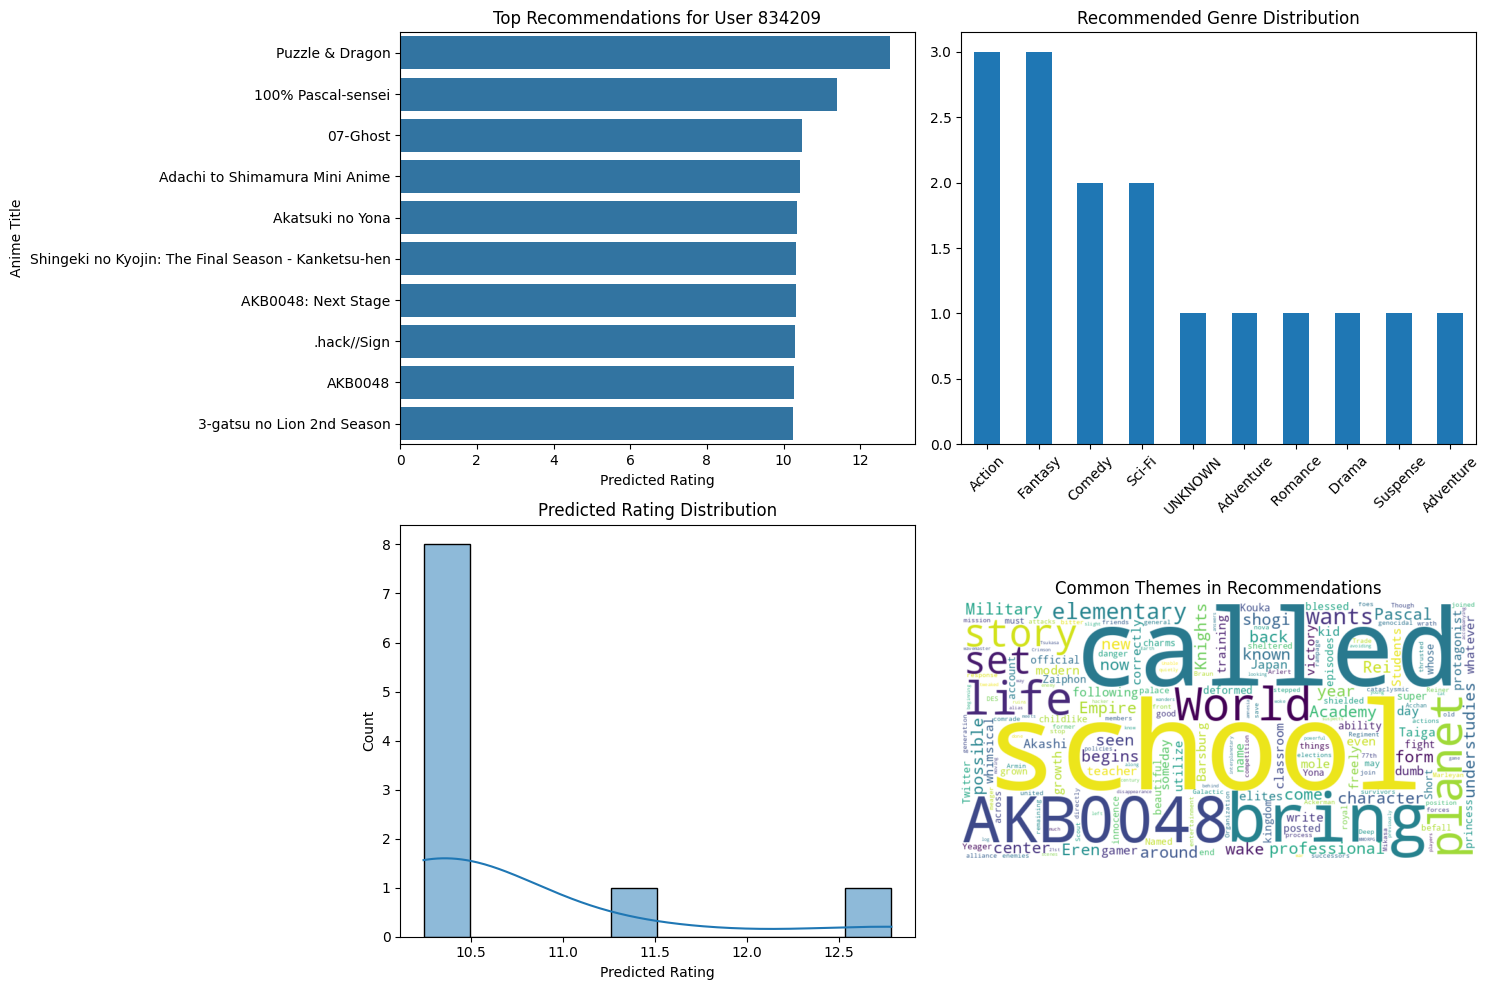

In [51]:
# Example usage
visualize_user_recommendations(user_id=834209)  # replace with actual user ID

This dashboard for user 834209, built using an ALS-based movie recommender system, offers several interesting insights into the system's predictions:

**Top Recommendations:**

* The top recommendations are clustered with relatively high predicted ratings, all above a score of 10. This suggests the model is fairly confident in these predictions for this user.
* The top recommended anime titles are diverse, including "Puzzle & Dragon," "100% Pascal-sensei," "07-Ghost," "Adachi to Shimamura Mini Anime," "Akatsuki no Yona," "Shingeki no Kyojin: The Final Season - Kanketsu-hen," "AKB0048: Next Stage," "hack//Sign," "AKB0048," and "3-gatsu no Lion 2nd Season." This variety indicates the model isn't overly narrow in its top suggestions.
* "Puzzle & Dragon" stands out with the highest predicted rating, suggesting it's the strongest recommendation for this user according to the model.

**Recommended Genre Distribution:**

* The model seems to heavily favor the "Action" and "Fantasy" genres for this user, with the highest number of recommendations falling into these categories.
* "Comedy" and "Sci-Fi" also have a significant presence in the recommendations.
* Interestingly, there's an "UNKNOWN" genre category with a notable number of recommendations. This might indicate issues with data labeling or movies that couldn't be categorized.
* Other genres like "Adventure," "Romance," "Drama," "Suspense," and "Horror" have fewer recommendations, suggesting the user's inferred preferences lean less towards these categories.

**Predicted Rating Distribution:**

* The distribution of predicted ratings appears somewhat skewed towards the higher end. A large number of recommendations have a predicted rating around 10.5.
* There's a secondary, smaller peak around a rating of 12.5.
* This distribution reinforces the observation from the top recommendations that the model is generally predicting high ratings for this user's potential interests.

**Common Themes in Recommendations:**

* The word cloud reveals prominent themes associated with the recommended anime. "School," "life," "world," "called," "story," "AKB0048," and "bring" are among the most frequent terms.
* Other recurring themes include "military," "elementary," "high," "wants," "set," "begins," and "stage."
* This suggests that many of the recommended anime likely involve school settings, slice-of-life elements, and potentially themes related to performance or groups (given the prominence of "AKB0048").

**Overall Insights:**

* The ALS model for user 834209 seems to believe this user has a strong preference for Action and Fantasy anime, often set in school environments and potentially involving group dynamics or performance-related storylines.
* The consistently high predicted ratings across the top recommendations suggest the model has identified anime it believes the user will likely enjoy.
* The presence of an "UNKNOWN" genre highlights a potential area for data improvement to ensure all items are correctly categorized.

In summary, this dashboard provides a good overview of the recommender system's output for a specific user, highlighting the top suggestions, the genre preferences inferred by the model, the distribution of predicted ratings, and the common themes present in the recommendations. This information can be valuable for understanding the model's behavior and identifying potential areas for refinement.

In [55]:
def visualize_genre_popularity():
    # Get top genres across all recommendations
    genres_df = top_n.select("Genres").toPandas()

    # Drop missing or empty genre fields
    genres_series = genres_df['Genres'].dropna().astype(str)

    # Split by comma and flatten the list of genres
    all_genres = genres_series.str.split(',').explode().str.strip()

    # Count top genres
    top_genres = all_genres.value_counts().head(15)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_genres.values, y=top_genres.index)
    plt.title('Most Recommended Genres Across All Users')
    plt.xlabel('Count in Recommendations')
    plt.tight_layout()
    plt.show()


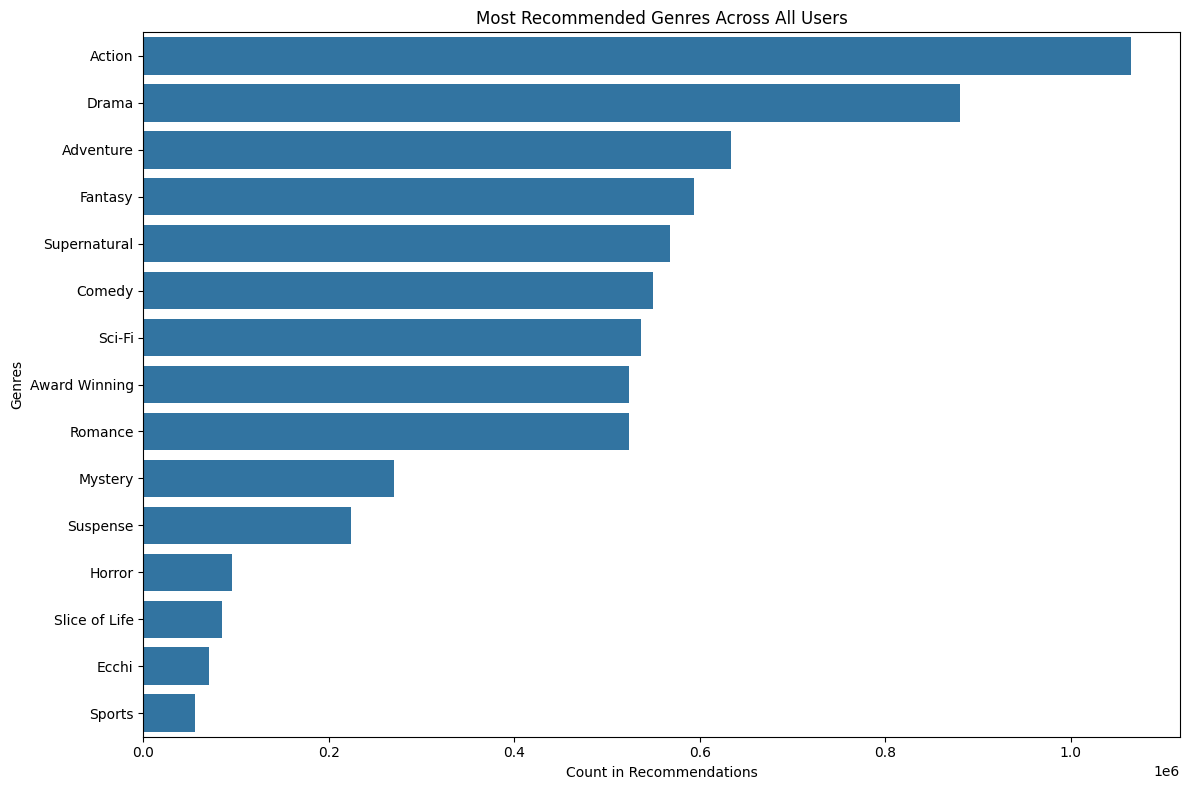

In [56]:
visualize_genre_popularity()

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

def visualize_anime_network(user_id):
    # Fetch top-k recommendations for a specific user
    user_recs = top_n.filter(col("user_id") == user_id).toPandas()

    if user_recs.empty:
        print(f"No recommendations found for user {user_id}")
        return

    G = nx.Graph()

    # Add anime nodes
    for _, row in user_recs.iterrows():
        G.add_node(row['Name'],
                   genres=row['Genres'],
                   rating=row['prediction'])

    # Add edges between anime that share genres
    for i, row1 in user_recs.iterrows():
        genres1 = set(row1['Genres'].split(','))
        for j, row2 in user_recs.iterrows():
            if i >= j:
                continue
            genres2 = set(row2['Genres'].split(','))
            shared = genres1.intersection(genres2)
            if shared:
                G.add_edge(row1['Name'], row2['Name'],
                           weight=len(shared),
                           genres=", ".join(shared))

    # Draw the network
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, seed=42)

    # Node size scaled by prediction score
    node_sizes = [G.nodes[n]['rating'] * 100 for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes,
                           node_color='lightcoral',
                           alpha=0.8)
    nx.draw_networkx_edges(G, pos,
                           width=1.0,
                           alpha=0.4)
    nx.draw_networkx_labels(G, pos,
                            font_size=10)

    plt.title(f'Anime Recommendation Network for User {user_id}')
    plt.axis('off')
    plt.show()


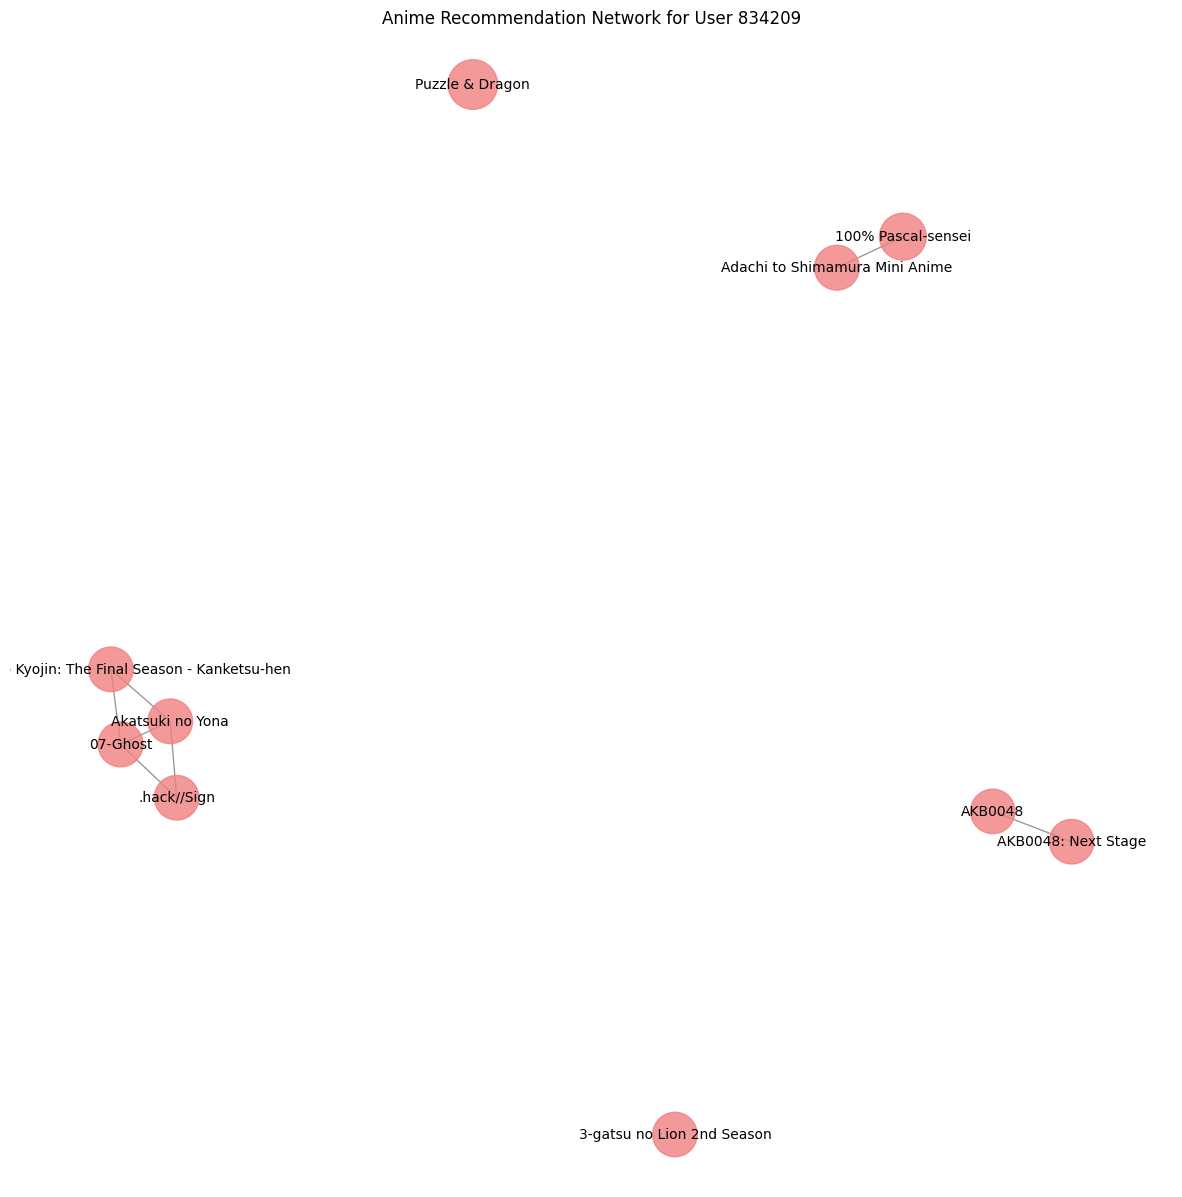

In [60]:
visualize_anime_network(user_id=834209)

This interactive network graph visualizes the relationships between the top anime recommendations for user 834209. The connections likely represent some form of similarity learned by the ALS recommender system, such as users who liked one anime also tending to like another. Here's a breakdown of the insights we can glean:

* **Clustering of Recommendations:** The graph shows distinct clusters of anime. This suggests that the model has identified groups of anime that are more closely related to each other in terms of user preferences.

    * One cluster includes "Akatsuki no Yona," "07-Ghost," "Shingeki no Kyojin: The Final Season - Kanketsu-hen," and "hack//Sign," with connections between them. This implies that users who enjoyed one of these titles were also likely to enjoy the others.
    * Another smaller cluster consists of "100% Pascal-sensei" and "Adachi to Shimamura Mini Anime," indicating a similarity in the user base that appreciates these two.
    * "AKB0048" and "AKB0048: Next Stage" are also clustered, which is expected as they are likely related series.
    * "Puzzle & Dragon" & "3-gatsu no Lion 2nd Season" stands alone, suggesting it might be somewhat distinct in its appeal compared to the other top recommendations for this user.

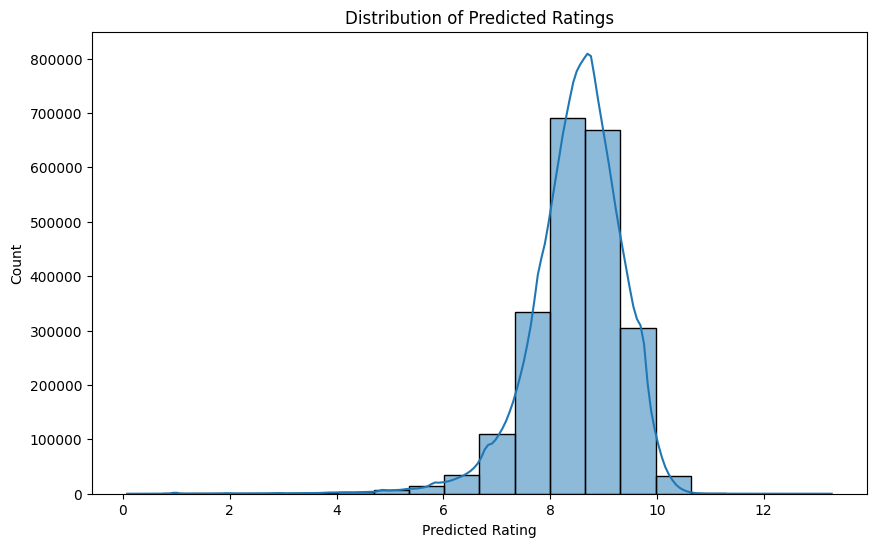

In [71]:
def visualize_recommendation_distribution():
    # Get prediction distribution
    pred_dist = top_n.select("prediction").toPandas()

    plt.figure(figsize=(10, 6))
    sns.histplot(pred_dist['prediction'], bins=20, kde=True)
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.show()

visualize_recommendation_distribution()

This histogram shows the **distribution of predicted ratings** from ALS (Alternating Least Squares) recommender system. Here’s a breakdown of key insights:

---

### **1. Normal-like Distribution Centered Around 8**
- Most predicted ratings are tightly **clustered around 8**, with a peak just slightly below or at 8.
- This is **expected** in ALS because the model minimizes squared error, which tends to **pull predictions toward the mean rating**.
- **Fewer very low or very high predictions** — suggesting the model is conservative and doesn’t make many extreme recommendations.

---

### **2. Very Few Low Ratings (0–5)**
- The **left tail** is small — this suggests the model **rarely predicts that a user will strongly dislike an anime**.
- This may be because of **ALS’s tendency to predict within a limited, safe range**, especially when **confidence values are uniform or unweighted**.

---

### 🧠 **Overall Insight**
> The ALS model is **predicting safely within a range**, generally between 6 and 10, with a strong peak around 8 — indicating it's confident about moderate-to-high user interest in the recommended anime.


In [69]:
def visualize_user_anime_heatmap(sample_users=100, sample_anime=20):
    from pyspark.sql.functions import avg

    # Sample distinct users and anime
    sampled_users_df = users_score_df.select("user_id").distinct().limit(sample_users)
    sampled_anime_df = anime_df.select("anime_id", "Name") \
                               .limit(sample_anime) \
                               .withColumnRenamed("Name", "anime_name")

    # Join and aggregate user scores
    interactions_df = users_score_df.join(sampled_users_df, on="user_id") \
                                    .join(sampled_anime_df, on="anime_id") \
                                    .groupBy("user_id", "anime_name") \
                                    .agg(avg("rating").alias("avg_rating"))

    # Convert to pandas
    interactions_pd = interactions_df.toPandas()

    # Pivot for heatmap
    heatmap_data = interactions_pd.pivot(index="user_id", columns="anime_name", values="avg_rating")

    # Plot
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Average Score'})
    plt.title('User-Anime Rating Heatmap')
    plt.xlabel('Anime')
    plt.ylabel('User ID')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

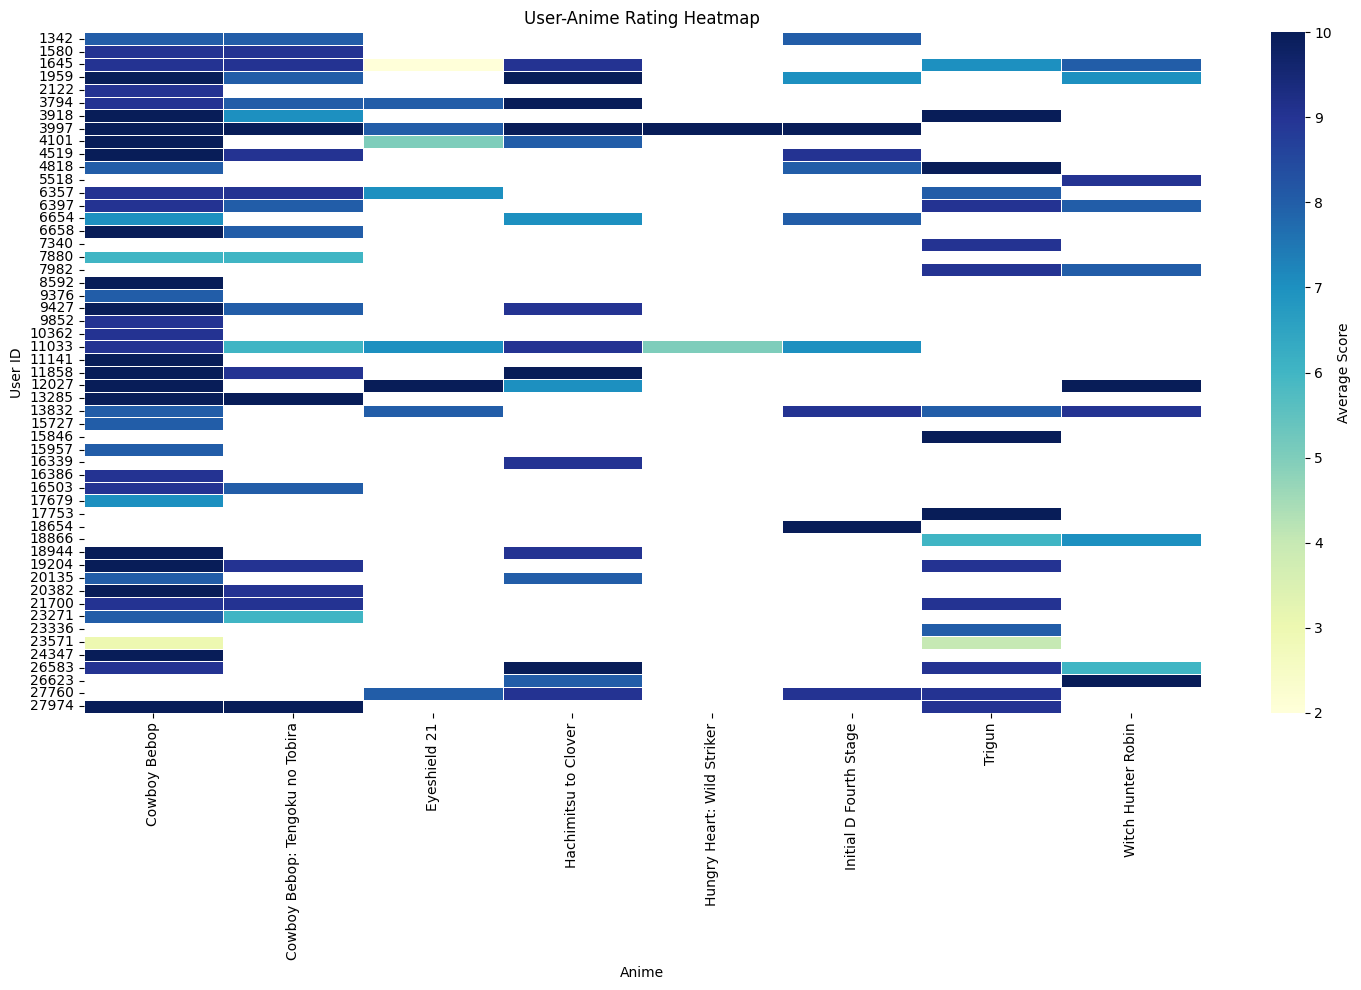

In [70]:
visualize_user_anime_heatmap(sample_users=100, sample_anime=20)